## 1.Importing Required Libraries

This section imports all required libraries for:

Deep learning (PyTorch)

Pretrained vision models (Torchvision)

Image processing (PIL)

Feature extraction (joblib for vectorizer)

Path handling

Graph visualization (matplotlib)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torchvision.transforms as transforms
from pathlib import Path
from PIL import Image
import joblib


## 2.Device Configuration

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


## 3.Image Model – Custom Classifier
Defines the custom classification head added to MobileNetV3.

Architecture:

The classifier consists of:
Linear layer (feature reduction)

ReLU activation

Dropout (regularization)

Second linear layer

ReLU

Dropout

Final linear layer → 4 output classes

In [6]:
def build_custom_classifier(in_features: int, num_classes: int) -> nn.Sequential:
    return nn.Sequential(
        # Layer 1
        nn.Linear(in_features, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.3),
        # Layer 2
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        # Layer 3 (Output layer)
        nn.Linear(256, num_classes),  # num_classes = 4
    )

## 4.Loading Pretrained Image Model
Loads:

Base MobileNetV3-Large

Custom classifier

Saved best weights

In [7]:
def load_pretrained_model(
    checkpoint_path: Path, num_classes: int = 4, device: torch.device | None = None
) -> nn.Module:
    """
    Load a pre-trained MobileNetV3 model from checkpoint.

    Args:
        checkpoint_path: Path to the checkpoint file (.pth)
        num_classes: Number of output classes (default: 4)
        device: Device to load model to (default: auto-detect)

    Returns:
        Loaded model ready for inference
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load base MobileNetV3-Large architecture
    model = models.mobilenet_v3_large(weights=None)  # Don't load ImageNet weights

    # Get input features for custom classifier
    first_layer = model.classifier[0]
    if isinstance(first_layer, nn.Linear):
        in_features = first_layer.in_features
    else:
        in_features = 960  # Default for MobileNetV3-Large

    # Build custom 3-layer classification head (same architecture as training)
    custom_classifier = build_custom_classifier(
        in_features=in_features,
        num_classes=num_classes,
    )

    # Replace classifier
    model.classifier = custom_classifier

    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    # Note that when loading the checkpoint, we are also loading the weights of the classifier layer. So, we just have to make sure that we are loading the classifier layer in the correct order.
    model.load_state_dict(checkpoint["model_state_dict"])

    # Move to device and set to eval mode
    model = model.to(device)
    model.eval()

    print(f"✓ Model loaded from {checkpoint_path}")
    print(f"  Checkpoint epoch: {checkpoint.get('epoch', 'N/A')}")
    print(f"  Validation accuracy: {checkpoint.get('val_accuracy', 'N/A'):.2f}%")
    print(f"  Device: {device}")

    return model


print("load_pretrained_model() function created!")

load_pretrained_model() function created!


## 5.Loading  Model Components
Loads:

Mobilenetv3_best

DistilBert Model(best_model.pth)

In [8]:
CHECKPOINT_DIR = Path("models")   # change if needed
image_model = load_pretrained_model(
    checkpoint_path=CHECKPOINT_DIR / "mobilenetv3_best.pth",
    num_classes=4,
    device=device
)

from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch

# Load tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Recreate architecture
text_model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=4   # MUST match training
)

# Load checkpoint
checkpoint = torch.load("best_model.pth", map_location=device)

# Load ONLY model weights
text_model.load_state_dict(checkpoint["model_state_dict"])

text_model = text_model.to(device)
text_model.eval()

print("DistilBERT loaded successfully ✅")




✓ Model loaded from models\mobilenetv3_best.pth
  Checkpoint epoch: 9
  Validation accuracy: 78.39%
  Device: cuda


c:\Users\gsanj\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBERT loaded successfully ✅


## 6.Recreate Text Model Architecture

In [9]:
import torch
from torch.utils.data import Dataset
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

class GarbageDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(
            texts.tolist(),
            truncation=True,
            padding=True,
            max_length=64
        )
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)  # 🔥 important
        return item

    def __len__(self):
        return len(self.labels)


## 7.Image Prediction Function

Takes image path and returns probability distribution.

Processing Steps:

Load image

Resize to 224x224

Normalize

Convert to tensor

Forward pass through model

Apply softmax to convert logits to probabilities

In [10]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

def predict_image_probs(image_path):

    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = image_model(image)
        probs = F.softmax(logits, dim=1)

    return probs


## 8.Text Prediction Function



In [11]:
def predict_text(text):
    model.eval()

    encoding = tokenizer(
        text,
        truncation=True,
        padding=True,
        max_length=64,
        return_tensors="pt"
    )

    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=1).item()

    class_names = ["Black", "Blue", "Green", "TTR"]

    return class_names[prediction]


In [12]:
import matplotlib.pyplot as plt
import numpy as np


## 9.Multimodal Fusion Strategy

In [13]:
def multimodal_predict(image_path, text_input, true_label=None,
                       image_weight=0.7, text_weight=0.3):

    # Load and process image
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Tokenize text properly for DistilBERT
    encoding = tokenizer(
        text_input,
        truncation=True,
        padding=True,
        max_length=64,
        return_tensors="pt"
    )

    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    with torch.no_grad():
        # Image logits
        image_logits = image_model(image_tensor)

        # DistilBERT logits
        text_outputs = text_model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        text_logits = text_outputs.logits

    # Convert to probabilities
    image_probs = torch.softmax(image_logits, dim=1)
    text_probs = torch.softmax(text_logits, dim=1)

    # Fusion
    final_probs = image_weight * image_probs + text_weight * text_probs
    final_logits = image_weight * image_logits + text_weight * text_logits

    final_index = torch.argmax(final_probs, dim=1).item()
    confidence = torch.max(final_probs).item()

    class_names = ["blue", "black", "green", "other"]

    final_probs_np = final_probs.cpu().numpy()[0]
    final_logits_np = final_logits.cpu().numpy()[0]

    print("\nDetailed Multimodal Output:")
    print("=" * 60)

    if true_label is not None:
        print(f"True Label: {true_label}")

    print("\nRaw Logits (Fusion pre-softmax):")
    for i, class_name in enumerate(class_names):
        print(f"  {class_name}: {final_logits_np[i]:.4f}")

    print("\nProbability Distribution (post-softmax):")
    for i, class_name in enumerate(class_names):
        print(f"  {class_name}: {final_probs_np[i]:.4f} ({final_probs_np[i]*100:.2f}%)")

    print(f"\nPredicted Class: {class_names[final_index]}")
    print(f"Confidence: {confidence*100:.2f}%")

    # Plot
    plt.figure(figsize=(8,5))
    colors = ["skyblue"] * len(class_names)
    colors[final_index] = "green"

    plt.bar(class_names, final_probs_np, color=colors)
    plt.ylim(0, 1)
    plt.title("Multimodal Fusion Prediction")
    plt.ylabel("Probability")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return class_names[final_index]


## 10.Output Testing


Detailed Multimodal Output:

Raw Logits (Fusion pre-softmax):
  blue: 1.5593
  black: 2.0018
  green: -5.6604
  other: -2.5505

Probability Distribution (post-softmax):
  blue: 0.3891 (38.91%)
  black: 0.6034 (60.34%)
  green: 0.0004 (0.04%)
  other: 0.0070 (0.70%)

Predicted Class: black
Confidence: 60.34%


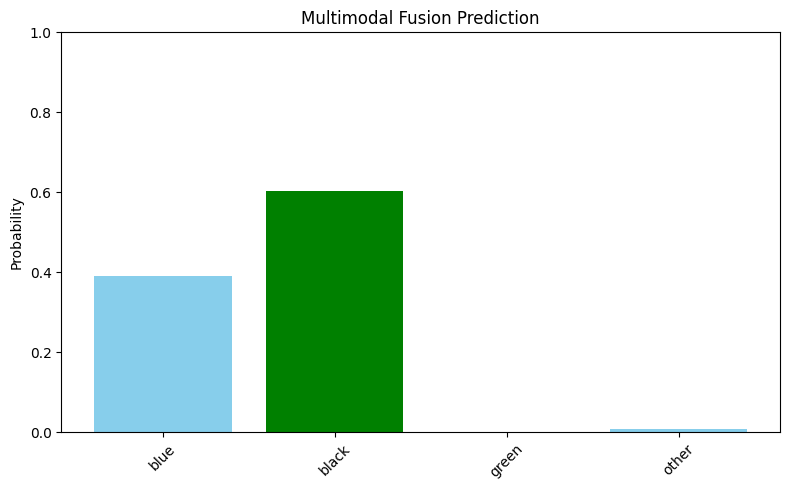

'black'

In [14]:
multimodal_predict("test.jpg","used plastic bottle")

## 11.Test Loader

In [15]:
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder(
    root="dataset/CVPR_2024_dataset_Test",
    transform=transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False
)

print("Test dataset loaded.")
print("Classes:", test_dataset.classes)
print("Total samples:", len(test_dataset))


Test dataset loaded.
Classes: ['Black', 'Blue', 'Green', 'TTR']
Total samples: 3432


Test List

In [16]:
import pandas as pd

df = pd.read_csv("dataset.csv", sep="\t")
df.columns = df.columns.str.strip().str.lower()

print(df.head())

import os

text_list = []

for path, _ in test_dataset.samples:

    filename = os.path.basename(path)
    name_without_ext = os.path.splitext(filename)[0]

    # Find corresponding text from dataset.csv
    row = df[df["text"] == name_without_ext]

    if not row.empty:
        text_value = row["text"].values[0]
    else:
        print(f"Warning: {name_without_ext} not found in CSV")
        text_value = name_without_ext  # fallback

    text_list.append(text_value)

print("text_list created successfully!")
print("Total test samples:", len(text_list))


                             text  label
0  acne treatment ointment tube 0  Black
1              Aero bar wrapper 1  Black
2       air freshener container 2  Black
3                  almonds sack 4  Black
4            aloe vera gel tube 5  Black
text_list created successfully!
Total test samples: 3432


## 12.Accuracy

In [17]:
def evaluate_multimodal(test_loader, text_list,
                        image_weight=0.7, text_weight=0.3):

    image_model.eval()
    text_model.eval()

    correct = 0
    total = 0
    text_index = 0  # track text position

    with torch.no_grad():
        for images, labels in test_loader:

            images = images.to(device)
            labels = labels.to(device)

            batch_size = images.size(0)

            # IMAGE (whole batch at once)
            image_logits = image_model(images)

            # TEXT (whole batch at once)
            batch_texts = text_list[text_index:text_index + batch_size]
            text_index += batch_size

            encoding = tokenizer(
                batch_texts,
                truncation=True,
                padding=True,
                max_length=64,
                return_tensors="pt"
            )

            input_ids = encoding["input_ids"].to(device)
            attention_mask = encoding["attention_mask"].to(device)

            text_outputs = text_model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            text_logits = text_outputs.logits

            # PROBABILITIES
            image_probs = torch.softmax(image_logits, dim=1)
            text_probs = torch.softmax(text_logits, dim=1)

            # FUSION
            final_probs = image_weight * image_probs + text_weight * text_probs
            final_preds = torch.argmax(final_probs, dim=1)

            correct += (final_preds == labels).sum().item()
            total += batch_size

    accuracy = correct / total

    print("\n==============================")
    print("MULTIMODAL FUSION ACCURACY")
    print("==============================")
    print(f"Total Samples: {total}")
    print(f"Correct Predictions: {correct}")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print("==============================")

    return accuracy


In [18]:
evaluate_multimodal(test_loader,text_list)



MULTIMODAL FUSION ACCURACY
Total Samples: 3432
Correct Predictions: 2586
Accuracy: 75.35%


0.7534965034965035